# Preparatory work



In [ ]:
import pandas as pd
import numpy as np
import ast
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import os
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import scipy.stats as stats
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy.stats import chi2_contingency

## load data

In [ ]:
df = pd.read_csv('../data/merged_video_all_new.csv')

## add round_id:
to make sure the speaker and the responder are in the same round

In [ ]:
def add_round_id(df, time_col="start"):
    """
    Infer round_id from the time column: a new round begins each time start returns to zero.
    """
    round_ids = []
    current_round = 1
    prev_time = -1

    for t in df[time_col]:
        if prev_time > t:  # back to 0s, so it's a new round
            current_round += 1
        round_ids.append(current_round)
        prev_time = t

    df = df.copy()
    df["round_id"] = round_ids
    return df

# add round_id
df = add_round_id(df, time_col="start")

## delete data with multiple strategies

not use in the this analysis

In [ ]:
def remove_multi_strategies(df):
    """
    Delete rows containing multiple strategies, and only keep rows where there is a single strategy in the annotation.
    The number of deleted rows and the number of retained rows will be printed.
    """
    valid_rows = []
    removed = 0

    for _, row in df.iterrows():
        try:
            strategies = ast.literal_eval(row["annotation"])
            # annotation is list
            if isinstance(strategies, list):
                if len(strategies) == 1:
                    r = row.copy()
                    r["strategy_type"] = str(strategies[0]).strip()
                    valid_rows.append(r)
                else:
                    removed += 1  #
            # annotation is not list
            else:
                r = row.copy()
                r["strategy_type"] = str(strategies).strip()
                valid_rows.append(r)
        except Exception:
            r = row.copy()
            r["strategy_type"] = str(row["annotation"]).strip()
            valid_rows.append(r)

    result_df = pd.DataFrame(valid_rows)
    print(f"Rows containing multiple strategies have been deleted: {removed}")
    print(f"Number of remaining rows: {len(result_df)} / Original total number of rows: {len(df)}")

    return result_df

In [ ]:
df_clean = remove_multi_strategies(df)
# Count the number of each strategy
strategy_counts = df_clean["strategy_type"].value_counts()
print("\n Strategy counts:\n", strategy_counts )

## normalize the data

In [ ]:
def standardize_vad(df, emos=["valence","arousal","dominance"]):
    """normalize data for each speaker"""
    df_std = df.copy()
    if "round_id" in df_std.columns:
        for emo in emos:
            df_std[f"{emo}_z"] = df_std.groupby(["round_id", "speaker"])[emo].transform(
                lambda x: (x - x.mean()) / x.std(ddof=0) if x.std(ddof=0) != 0 else x - x.mean()
            )
    if "topic" in df_std.columns:
        for emo in emos:
            df_std[f"{emo}_z"] = df_std.groupby(["topic","speaker"])[emo].transform(
                lambda x: (x - x.mean()) / x.std(ddof=0) if x.std(ddof=0) != 0 else x - x.mean()
            )
    else:
        for emo in emos:
            df_std[f"{emo}_z"] = df_std.groupby(["speaker"])[emo].transform(
                lambda x: (x - x.mean()) / x.std(ddof=0) if x.std(ddof=0) != 0 else x - x.mean()
            )
    return df_std

In [ ]:
# normalize data
# df_std = standardize_vad(df_clean)
df_std = standardize_vad(df)
# Process null values and retain the first strategy of the data containing multiple strategies
# df_std["strategy_type"] = df_std["annotation"]
df_std["strategy_type"] = df_std["annotation"].apply(
    lambda x: ast.literal_eval(x)[0] if isinstance(x, str) and len(ast.literal_eval(x)) >= 1 else "No Strategy"
)
df_std.columns

Index(['speaker', 'timestamp', 'utterance', 'annotation', 'vote', 'start',
       'end', 'startRole', 'endRole', 'player_index', 'dominance', 'valence',
       'arousal', 'round_id', 'valence_z', 'arousal_z', 'dominance_z',
       'strategy_type'],
      dtype='object')

# Analysis1: try to figure out what kind of speaker's emotion will trigger the responder to use strategies

## function part

In [ ]:
def build_trigger_labels(df_std, time_window=3):
    """
    For each utterance, determine whether it causes others to use strategies within the same round's time window.
    return a new df, include speaker's VAD, is_strategy(speaker), responder, triggered(1/0) and triggered_strategy_type
    """
    df_sorted = df_std.sort_values(["round_id", "start"]).reset_index(drop=True)
    records = []

    for idx, row in df_sorted.iterrows():
        curr_speaker = row["speaker"]
        curr_round = row["round_id"]
        curr_stop = row["end"]

        triggered = 0
        for j in range(idx + 1, len(df_sorted)):
            next_row = df_sorted.iloc[j]
            if next_row["round_id"] != curr_round:
                break
            if next_row["start"] > curr_stop + time_window:
                break
            if next_row["speaker"] != curr_speaker and next_row["strategy_type"] != "No Strategy":
                triggered = 1
                break

        records.append({
            "speaker": curr_speaker,
            "round_id": curr_round,
            "valence_z": row["valence_z"],
            "arousal_z": row["arousal_z"],
            "dominance_z": row["dominance_z"],
            "utterance": row["utterance"],
            "is_strategy": row["strategy_type"] != "No Strategy",
            "triggered": triggered,
            "listener": next_row["speaker"] if triggered else "None",
            "triggered_strategy_type": next_row["strategy_type"] if triggered else "None",
            "triggered_utterance": next_row["utterance"] if triggered else None
        })

    return pd.DataFrame(records)

In [ ]:
def cluster_vad_profiles(df, n_clusters=4,
                         vad_cols=["valence_z","arousal_z","dominance_z"],
                         label_col="triggered_strategy_type",
                         random_state=42):
    # Cluster the VAD features of the triggering events to view typical emotional patterns.

    df_clean = df.dropna(subset=vad_cols).copy()
    X_scaled = df_clean[vad_cols].values

    # clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=20)
    clusters = kmeans.fit_predict(X_scaled)
    df_clean["cluster"] = clusters
    centers = pd.DataFrame(kmeans.cluster_centers_, columns=vad_cols)
    centers["cluster"] = np.arange(n_clusters)

    # Relationship table between clustering and strategy
    cluster_dist = (
        df_clean.groupby("cluster")[label_col]
        .value_counts(normalize=True)
        .rename("ratio")
        .reset_index()
        .sort_values(["cluster","ratio"], ascending=[True,False])
    )

    print("\nClustering centers (z-score VAD space):")
    print(centers.round(3))
    return df_clean, centers, cluster_dist

In [ ]:
def compute_enrichment(df,
                       cluster_col="cluster",
                       strategy_col="triggered_strategy_type",
                       alpha=1):
    """
    compute:
      - baseline: P(strategy)
      - within-cluster: P(strategy | cluster)
      - lift = P(strategy|cluster)/P(strategy): lift > 1 → enriched, lift < 1 → depleted
      - log2_lift = log2(lift): (symmetric scale)positive = enriched, negative = depleted, 0 = no difference
      - Pearson standardized residuals:(Observed - Expected) / sqrt(Expected)
            measures how much each cell differs from what is expected under independence
            positive: more than expected (enriched), negative: less than expected (depleted)
      - Cramer's V and the overall chi-square test

    alpha: Laplace smoothing (to avoid infinity caused by small classes being 0), with alpha=1 commonly used.
    return:
      long_df: Metrics for each cluster×strategy
      stats: {chi2, dof, p, cramer_v}:
        Chi-square statistic,
        Degrees of Freedom(7 strategy * 4 clusters),
        p-value,
        Cramér’s V effect size: how strong the association is, independent of sample size
    """
    # cluster × strategy
    ct = pd.crosstab(df[cluster_col], df[strategy_col])
    clusters = ct.index
    strategies = ct.columns

    # Avoid calculation errors caused by 0
    ct_sm = ct + alpha

    # Probability
    p_s = (ct_sm.sum(axis=0) / ct_sm.values.sum())              # P(s)
    p_s_given_c = ct_sm.div(ct_sm.sum(axis=1), axis=0)          # P(s|c)

    # lift & log2 lift
    lift = p_s_given_c.div(p_s, axis=1)
    log2_lift = np.log2(lift)

    # Standardized residual
    chi2, p, dof, exp = chi2_contingency(ct)  # Do chi-square with raw counts
    exp_df = pd.DataFrame(exp, index=clusters, columns=strategies)
    std_resid = (ct - exp_df) / np.sqrt(exp_df)

    # Cramer's V
    n = ct.values.sum()
    k = min(ct.shape)
    cramer_v = np.sqrt(chi2 / (n * (k - 1))) if k > 1 else np.nan

    long_df = (
        pd.concat({
            "p_s_given_c": p_s_given_c.stack(),
            "lift": lift.stack(),
            "log2_lift": log2_lift.stack(),
            "std_resid": std_resid.stack()
        }, axis=1)
        .reset_index()
        .rename(columns={"level_0": "cluster", "level_1": "strategy"})
        .sort_values(["cluster","log2_lift"], ascending=[True, False])
    )

    stats = {"chi2": chi2, "dof": dof, "p": p, "cramer_v": cramer_v}
    return long_df, stats

def permutation_pvals_for_lift(df, n_perm=1000,
                               cluster_col="cluster",
                               strategy_col="triggered_strategy_type",
                               alpha=1, random_state=42):
    """
    Perform a permutation test on the log2_lift of each cluster×strategy:
    Shuffle the strategy labels(n_perm times) to form a null distribution and calculate the two-tailed p-value.
    Return: Add 'p_perm' to enrich_df
    """
    rng = np.random.default_rng(random_state)
    enrich_obs, _ = compute_enrichment(df, cluster_col, strategy_col, alpha)
    key = ["cluster",strategy_col]

    # log2_lift
    obs = enrich_obs.set_index(key)["log2_lift"]

    # Shuffle the strategy labels
    perms = []
    for _ in range(n_perm):
        shuf = df.copy()
        shuf[strategy_col] = rng.permutation(shuf[strategy_col].values)
        e, _ = compute_enrichment(shuf, cluster_col, strategy_col, alpha)
        perms.append(e.set_index(key)["log2_lift"].reindex(obs.index).values)
    perms = np.vstack(perms)

    # For each cell, check how many times the "random log₂(lift)" in the random permutations
    # is more extreme (with a larger absolute value) than the real one.
    pvals = (np.sum(np.abs(perms) >= np.abs(obs.values), axis=0) + 1) / (n_perm + 1)

    out = enrich_obs.copy()
    out["p_perm"] = pvals
    return out.sort_values(["cluster","log2_lift"], ascending=[True, False])


def report_top_by_enrichment(enrich_df, topk=3, min_count=20,
                             df_counts=None, cluster_col="cluster", strategy_col="strategy"):
    """
    Top-K strategies within each cluster ranked by log₂-lift
    """
    if df_counts is None:
        df_counts = pd.crosstab(df_clustered["cluster"], df_clustered[strategy_col])

    merged = enrich_df.merge(df_counts.stack().rename("n").reset_index()
                             .rename(columns={"level_0":cluster_col, "level_1":strategy_col}),
                             on=[cluster_col, strategy_col], how="left")
    out = (merged[merged["n"]>=min_count]
           .sort_values(["cluster","log2_lift"], ascending=[True, False])
           .groupby("cluster").head(topk))
    return out[["cluster",strategy_col,"n","p_s_given_c","lift","log2_lift","std_resid","p_perm"]]

In [ ]:
def plot_enrichment_clustermap(enrich_df,
                               cluster_col="cluster",
                               strategy_col="triggered_strategy_type",
                               value_col="log2_lift",
                               p_col="p_perm",
                               sig_level=0.05,
                               cmap="RdBu_r",
                               figsize=(8,6),
                               method="ward",       # 'single','complete','average','ward'
                               metric="euclidean"   # 'euclidean','cosine', 'correlation', 'manhattan'

                               ):
    # row=cluster，column=strategy
    pivot = enrich_df.pivot(index=cluster_col,
                            columns=strategy_col,
                            values=value_col)

    pmat = enrich_df.pivot(index=cluster_col,
                           columns=strategy_col,
                           values=p_col).loc[pivot.index, pivot.columns]

    g = sns.clustermap(
        pivot,
        cmap=cmap,
        center=0,
        method=method,
        metric=metric,
        row_cluster=True,
        col_cluster=True,
        linewidths=0.5,
        linecolor="gray",
        figsize=figsize,
        cbar_kws={"label": "log₂(lift)"}
    )

    row_order = g.dendrogram_row.reordered_ind
    col_order = g.dendrogram_col.reordered_ind

    ax = g.ax_heatmap
    pvals = pmat.values
    for i_new, i_old in enumerate(row_order):
        for j_new, j_old in enumerate(col_order):
            if np.isfinite(pvals[i_old, j_old]) and pvals[i_old, j_old] < sig_level:
                ax.text(j_new + 0.5, i_new + 0.5, "*",
                        ha="center", va="center", fontsize=9, color="black")

    ax.set_xlabel("Triggered Strategy Type")
    ax.set_ylabel("Cluster (VAD Profile)")
    ax.set_title("Bidirectional hierarchical clustering of log₂(lift)", pad=12)

    plt.show()

## running

In [ ]:
# build data with trigger labels with tw=3
df_trigger_vad = build_trigger_labels(df_std, time_window=3)
# Cluster the VAD features of the triggering events
df_clustered, centers, cluster_dist = cluster_vad_profiles(
    df_trigger_vad,
    n_clusters=4,
    vad_cols=["valence_z","arousal_z","dominance_z"],
    label_col="triggered_strategy_type"
)


Clustering centers (z-score VAD space):
   valence_z  arousal_z  dominance_z  cluster
0      0.312     -0.233       -0.230        0
1      1.125      1.037        1.013        1
2     -0.979      0.661        0.689        2
3     -0.697     -1.277       -1.280        3


In [ ]:
df_trigger_vad.columns

Index(['speaker', 'round_id', 'valence_z', 'arousal_z', 'dominance_z',
       'utterance', 'is_strategy', 'triggered', 'listener',
       'triggered_strategy_type', 'triggered_utterance'],
      dtype='object')

In [ ]:
# compute enrichment
enrich_df, stats = compute_enrichment(df_clustered)
enrich_perm = permutation_pvals_for_lift(df_clustered, n_perm=1000)
# filter log₂-lift > 0 and p_perm < 0.05:the cases where a strategy truly occurs more often in that emotion cluster
sig = enrich_perm[(enrich_perm["log2_lift"]>0) & (enrich_perm["p_perm"]<0.05)]
top = report_top_by_enrichment(enrich_perm, topk=3, min_count=25,strategy_col="triggered_strategy_type")
print(stats)  # chi2, p, cramer_v
sig
# top

{'chi2': np.float64(59.7165278665554), 'dof': 18, 'p': np.float64(2.2735059585065784e-06), 'cramer_v': np.float64(0.04454659685186763)}


,cluster,triggered_strategy_type,p_s_given_c,lift,log2_lift,std_resid,p_perm
13,1,None,0.465966,1.096924,0.133463,3.086853,0.000999
15,2,Call for Action,0.059111,1.231049,0.299888,2.288381,0.023976
16,2,Defense,0.109917,1.144570,0.194806,2.027461,0.031968
26,3,Interrogation,0.178201,1.140285,0.189394,2.728028,0.002997


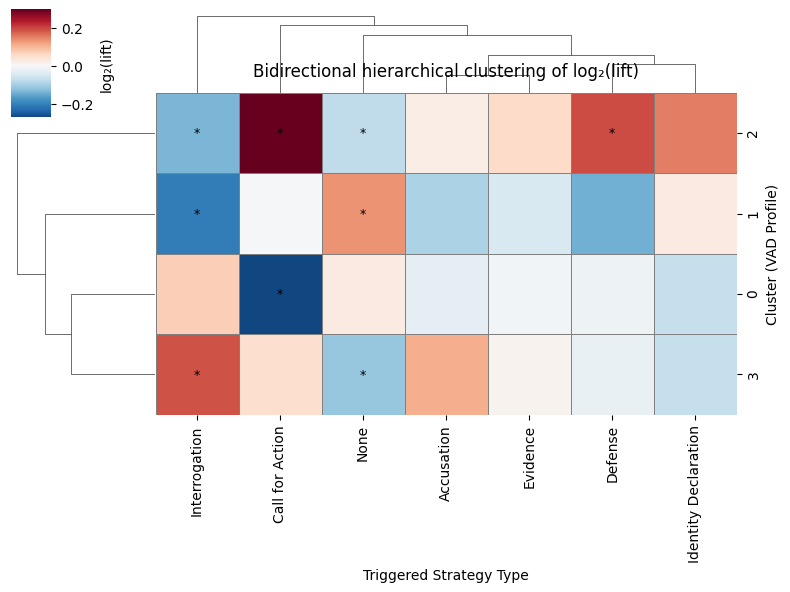

In [ ]:
plot_enrichment_clustermap(
    enrich_perm,
    cluster_col="cluster",
    strategy_col="triggered_strategy_type",
    value_col="log2_lift",
    p_col="p_perm",
    sig_level=0.05
)

In [ ]:
import pymc as pm
import numpy as np
import pandas as pd
import arviz as az

def fit_emotion_strategy_glmm(
    df,
    vad_cols=("valence", "arousal", "dominance"),
    listener_col="listener",
    speaker_col="speaker",
    round_col="round_id",
    strategy_col="triggered_strategy_type",
    random_slopes=True,
    include_round=True,
    draws=1000, tune=1000, chains=4, cores=4,
    target_accept=0.9, max_treedepth=10,
    fast_mode=False
):
    """
    Bayesian hierarchical multinomial logistic regression:
    speaker's emotion (VAD) → listener's strategy choice (multi-category),
    with optional random slopes and round-level random intercepts.
    """

    data = df.copy()
    X = data[list(vad_cols)].to_numpy()

    # Factorize strategy categories
    y, strategies = pd.factorize(data[strategy_col])
    n_class = len(strategies)
    n_samples = len(data)
    n_features = len(vad_cols)

    listener_idx, listeners = pd.factorize(data[listener_col])
    n_listeners = len(listeners)

    if include_round:
        round_idx, rounds = pd.factorize(data[round_col])
        n_rounds = len(rounds)
    else:
        round_idx, n_rounds = None, 0

    with pm.Model() as model:
        # Global priors
        alpha_bar = pm.Normal("alpha_bar", 0, 1, shape=n_class)
        sigma_alpha = pm.Exponential("sigma_alpha", 1)

        if random_slopes:
            beta_bar = pm.Normal("beta_bar", 0, 1, shape=(n_class, n_features))
            sigma_beta = pm.Exponential("sigma_beta", 1, shape=(n_class, n_features))
            # Listener-level random effects
            a_listener = pm.Normal("a_listener", 0, sigma_alpha, shape=(n_listeners, n_class))
            b_listener = pm.Normal("b_listener", 0, sigma_beta, shape=(n_listeners, n_class, n_features))

            eta = (
                alpha_bar
                + a_listener[listener_idx]
                + pm.math.sum(X[:, None, :] * b_listener[listener_idx], axis=2)
            )
        else:
            beta = pm.Normal("beta", 0, 1, shape=(n_class, n_features))
            a_listener = pm.Normal("a_listener", 0, sigma_alpha, shape=(n_listeners, n_class))
            eta = alpha_bar + a_listener[listener_idx] + pm.math.dot(X, beta.T)

        # Round-level random intercept
        if include_round:
            sigma_round = pm.Exponential("sigma_round", 1)
            a_round = pm.Normal("a_round", 0, sigma_round, shape=(n_rounds, n_class))
            eta += a_round[round_idx]

        # Softmax link for multinomial probabilities
        p = pm.Deterministic("p", pm.math.softmax(eta, axis=1))

        # Likelihood (multinomial / categorical)
        y_obs = pm.Categorical("y_obs", p=p, observed=y)

        # Sampling
        if fast_mode:
            idata = pm.sample(
                draws=300, tune=300, chains=2, cores=2,
                target_accept=0.8, max_treedepth=10, progressbar=True
            )
        else:
            idata = pm.sample(
                draws=draws, tune=tune, chains=chains, cores=cores,
                target_accept=target_accept, max_treedepth=max_treedepth, progressbar=True
            )

    return model, idata, strategies

In [ ]:
model, idata, strategies = fit_emotion_strategy_glmm(
    df_trigger_vad,
    vad_cols=("valence_z", "arousal_z", "dominance_z"),
    listener_col="responder",
    strategy_col="triggered_strategy_type",
    random_slopes=False,
    include_round=False,
    fast_mode=True
)

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [ ]:
az.summary(idata, var_names=["alpha_bar", "beta"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha_bar[0],-3.373,0.496,-4.303,-2.460,0.026,0.015,347.0,418.0,1.01
alpha_bar[1],1.415,0.421,0.541,2.116,0.026,0.016,263.0,347.0,1.00
alpha_bar[2],-0.159,0.426,-1.002,0.563,0.025,0.015,280.0,375.0,1.00
alpha_bar[3],0.374,0.424,-0.358,1.115,0.027,0.014,254.0,461.0,1.01
alpha_bar[4],1.199,0.428,0.430,1.993,0.026,0.014,262.0,411.0,1.00
alpha_bar[5],0.449,0.427,-0.306,1.275,0.027,0.015,246.0,349.0,1.01
alpha_bar[6],0.282,0.423,-0.514,1.074,0.027,0.015,247.0,272.0,1.01
"beta[0, 0]",0.026,0.447,-0.781,0.930,0.032,0.018,195.0,260.0,1.02
"beta[0, 1]",-0.031,0.654,-1.235,1.294,0.026,0.028,649.0,436.0,1.00
"beta[0, 2]",0.072,0.628,-1.130,1.215,0.029,0.024,475.0,415.0,1.00


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

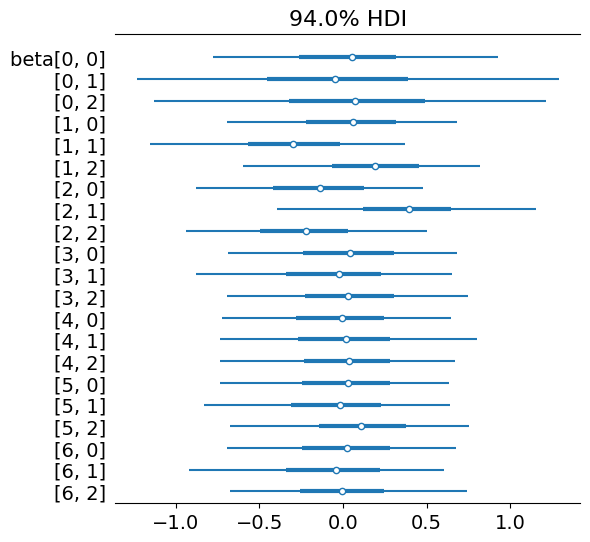

In [ ]:
vars_available = list(idata.posterior.data_vars)
vars_to_plot = [v for v in ["b_listener", "beta", "beta_bar"] if v in vars_available]
az.plot_forest(idata, var_names=vars_to_plot, combined=True)

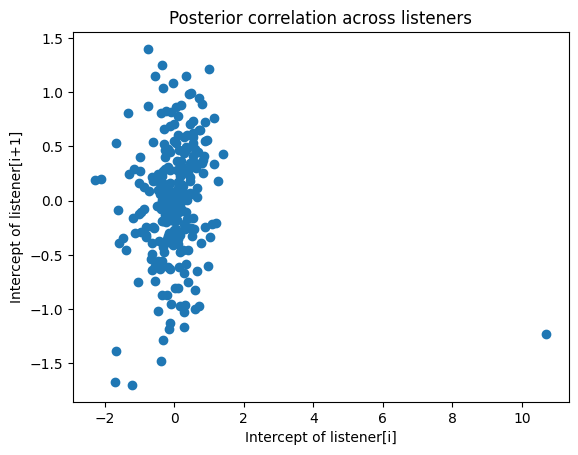

In [ ]:
import matplotlib.pyplot as plt

# 假设 a_listener 是每个听者的截距参数 (n_listeners,)
a_post = idata.posterior["a_listener"].mean(dim=("chain","draw")).values

plt.scatter(a_post[:-1], a_post[1:])
plt.xlabel("Intercept of listener[i]")
plt.ylabel("Intercept of listener[i+1]")
plt.title("Posterior correlation across listeners")
plt.show()

In [ ]:
np.argmax(a_post)
a_post[np.argmax(a_post)]
idx_max = np.argmax(a_post)
idx_min = np.argmin(a_post)

print("最大值索引:", idx_max, "值:", a_post[idx_max])
print("最小值索引:", idx_min, "值:", a_post[idx_min])
listener_idx, listeners = pd.factorize(df_trigger_vad["responder"])
print("离群听者:", listeners[idx_max])

最大值索引: 0 值: [10.70466067 -2.26435049 -1.32469601 -1.60378772 -2.11803162 -1.67883409
 -1.5995158 ]
最小值索引: 1 值: [-1.22586086  0.19435963  0.80928618 -0.08180908  0.20126917  0.53546854
 -0.38636991]
离群听者: None


## a

In [ ]:
def plot_trigger_boxplots_by_strategy(df_trigger, emo_cols=["valence_z", "arousal_z", "dominance_z"]):
    """
    Compare VAD values of speakers grouped by the strategy they triggered (or None).
    This shows which emotional states are likely to provoke different strategies in responders.
    """

    for emo in emo_cols:
        plt.figure(figsize=(8, 4))
        sns.boxplot(data=df_trigger, x="triggered_strategy_type", y=emo)
        plt.title(f"{emo} of Speakers by Triggered Strategy Type")
        plt.xticks(rotation=45)
        plt.xlabel("Triggered Strategy Type")
        plt.ylabel(f"{emo} (z-score)")
        plt.tight_layout()
        plt.show()

In [ ]:
plot_trigger_boxplots_by_strategy(df_trigger_vad)

with more data

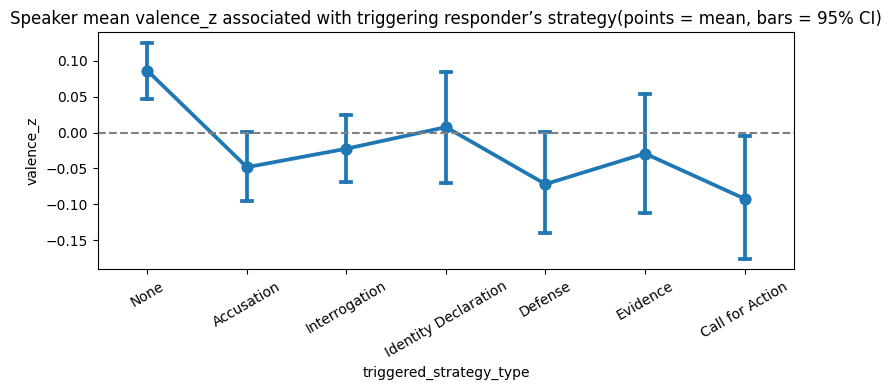

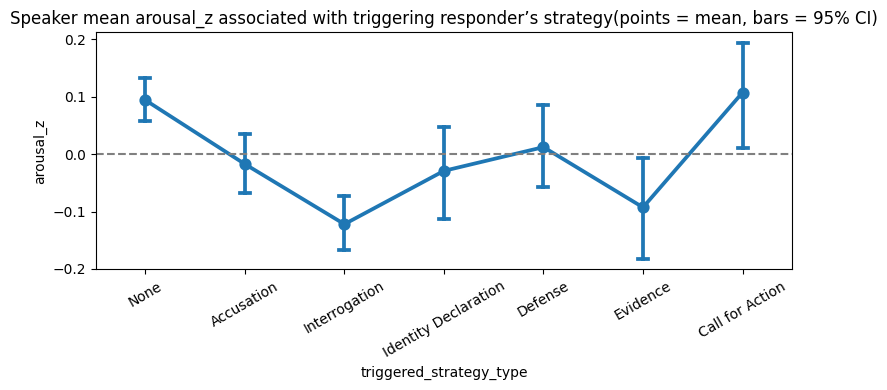

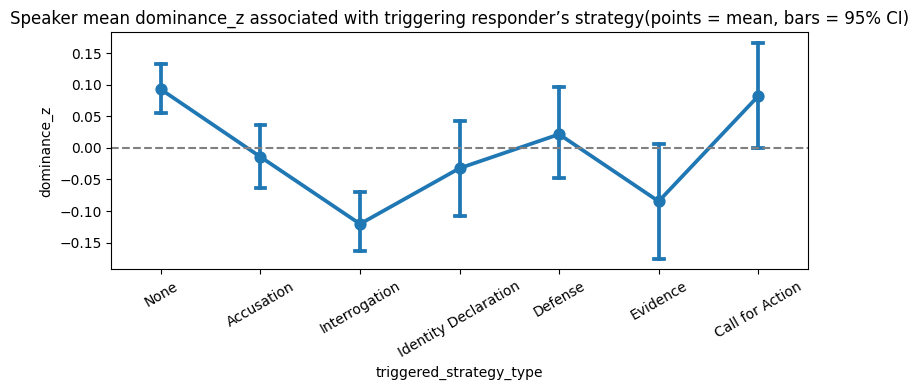

In [ ]:
def plot_mean_triggered(df, emo_cols=["valence_z", "arousal_z", "dominance_z"]):
  order = ['None', 'Accusation', 'Interrogation',
         'Identity Declaration', 'Defense', 'Evidence', 'Call for Action']
  for emo in emo_cols:
    plt.figure(figsize=(8, 4))
    # sns.pointplot(data=df_triggered, x="triggered_strategy_type", y=emo, errorbar='ci', capsize=.1)
    sns.pointplot(
    data=df_trigger_vad,
    x="triggered_strategy_type",
    y=emo,
    order=order,
    errorbar="ci",
    capsize=.1
    )
    plt.xticks(rotation=30)
    # plt.title("Mean "+ emo +" by Responder’s subsequent strategy")
    plt.title("Speaker mean "+emo+ " associated with triggering responder’s strategy(points = mean, bars = 95% CI)")
    plt.axhline(0, color="gray", linestyle="--")
    plt.tight_layout()
    plt.show()
plot_mean_triggered(df_trigger_vad)

### ANOVA
How do the speaker's vad features specifically affect which strategy the responder uses?\
The ad value can more significantly distinguish the types of strategies used by responders.

In [ ]:
def ANOVA_triggered(df, emo_cols=["valence_z", "arousal_z", "dominance_z"]):
  for dim in emo_cols:
      groups = df.groupby("triggered_strategy_type")[dim].apply(list)
      f_stat, p_val = f_oneway(*groups)
      print(f"ANOVA for {dim}: F = {f_stat:.3f}, p = {p_val:.5f}")

ANOVA_triggered(df_trigger_vad)

ANOVA for valence_z: F = 10.865, p = 0.00000
ANOVA for arousal_z: F = 13.984, p = 0.00000
ANOVA for dominance_z: F = 12.445, p = 0.00000


In [ ]:
print(df_trigger_vad.groupby("triggered_strategy_type")["dominance_z"].mean())

triggered_strategy_type
Accusation             -0.011636
Call for Action         0.062080
Defense                 0.045376
Evidence               -0.078818
Identity Declaration   -0.019357
Interrogation          -0.111090
None                    0.072032
Name: dominance_z, dtype: float64


In [ ]:
def tukey_result(df, emo_cols=["valence_z", "arousal_z", "dominance_z"]):
    order = ['None', 'Accusation', 'Interrogation', 'Defense', 'Evidence', 'Call for Action', 'Identity Declaration']
    df["triggered_strategy_type"] = pd.Categorical(
        df["triggered_strategy_type"],
        categories=order,
        ordered=True
    )
    for emo in emo_cols:
      result = pairwise_tukeyhsd(
          endog=df[emo],
          groups=df["triggered_strategy_type"],
          alpha=0.05
      )
      print(result.summary())

tukey_result(df_trigger_vad)

              Multiple Comparison of Means - Tukey HSD, FWER=0.05              
       group1               group2        meandiff p-adj   lower  upper  reject
-------------------------------------------------------------------------------
          Accusation      Call for Action  -0.0921 0.1701 -0.2021 0.0178  False
          Accusation              Defense   0.0474 0.7094 -0.0423  0.137  False
          Accusation             Evidence   0.0131 0.9999  -0.102 0.1283  False
          Accusation Identity Declaration    0.041 0.9334 -0.0707 0.1527  False
          Accusation        Interrogation   0.0183 0.9932   -0.06 0.0966  False
          Accusation                 None   0.1384    0.0  0.0657 0.2112   True
     Call for Action              Defense   0.1395 0.0074  0.0233 0.2557   True
     Call for Action             Evidence   0.1053 0.2593 -0.0315 0.2421  False
     Call for Action Identity Declaration   0.1331 0.0526 -0.0008 0.2671  False
     Call for Action        Interrogatio

# Try the method on new dataset(political topic)


1.  two sentence(with vad)
2.  relation: neither, attack, support
3.  speaker
4. timelabel



## preprocess the data
1. keep column: vad,speaker,realtion
2. normalize vad via z-score

In [ ]:
#load data
df = pd.read_csv('../data/final_dataset_with_VAD.csv')

In [ ]:
df.columns

Index(['_unit_id', '_golden', '_unit_state', '_trusted_judgments',
       'confidence', 'confidence:stddev', 'relation', 'relation:confidence',
       'orig__golden', 'context', 'pair_id', 'relation_gold',
       'relation_gold_reason', 'sentence_1', 'sentence_2', 'speaker_1',
       'speaker_2', 'topic', 'arousal_1', 'dominance_1', 'valence_1',
       'start_1', 'end_1', 'arousal_2', 'dominance_2', 'valence_2', 'start_2',
       'end_2'],
      dtype='object')

In [ ]:
def process(df, columns_to_keep):
  # keep useful columns
  df = df[columns_to_keep].copy()

  # standardize per speaker's vad by z-score
  speaker_cols = [1,2]
  for col in speaker_cols:
    df_temp = df[['topic', f'speaker_{col}', f'valence_{col}', f'arousal_{col}', f'dominance_{col}']].copy()
    df_temp.rename(columns={
        f'speaker_{col}': 'speaker',
        f'valence_{col}': 'valence',
        f'arousal_{col}': 'arousal',
        f'dominance_{col}': 'dominance'
    }, inplace=True)
    df_std = standardize_vad(df_temp, emos=["valence","arousal","dominance"])
    df[f'valence_{col}_z'] = df_std['valence_z']
    df[f'arousal_{col}_z'] = df_std['arousal_z']
    df[f'dominance_{col}_z'] = df_std['dominance_z']
  return df

columns_to_keep = ['relation', 'context', 'pair_id', 'sentence_1', 'sentence_2', 'speaker_1',
       'speaker_2', 'topic', 'arousal_1', 'dominance_1', 'valence_1', 'arousal_2', 'dominance_2', 'valence_2']

df = process(df, columns_to_keep)
display(df.head())

,relation,context,pair_id,sentence_1,sentence_2,speaker_1,speaker_2,topic,arousal_1,dominance_1,valence_1,arousal_2,dominance_2,valence_2,valence_1_z,arousal_1_z,dominance_1_z,valence_2_z,arousal_2_z,dominance_2_z
0,neither,"<strong>Kamala Harris:</strong> ""Please vote.""...",n160434b07p3539,And I have every confidence that the same Amer...,And I think that movement of Americans has onl...,Mike Pence,Mike Pence,Election,0.472522,0.583801,0.558834,0.362231,0.484693,0.490294,0.180627,0.371759,0.698438,-0.102996,-1.231348,-1.205770
1,neither,"<strong>Donald Trump:</strong> ""Look what happ...",n010145b07p4345,This is ridiculous.,Absolutely ridiculous.,Joe Biden,Joe Biden,Racism,0.681421,0.695370,0.295086,0.742416,0.733684,0.455172,-1.138138,0.923562,0.699793,0.090172,1.572957,1.282541
2,neither,"<strong>Donald Trump:</strong> ""And you’ll get...",n000798b07p9495,But let me just tell you-,In [crosstalk 00:16:04]?,Donald Trump,Joe Biden,Economy,0.678167,0.737232,0.456352,0.778007,0.807455,0.230637,-0.312776,-0.121010,0.646728,-2.040182,1.502713,2.009789
3,attack,"<strong>Kristen Welker:</strong> ""I have one f...",n030538b07p3536,"By the way, I have a transition from the old i...","Oh, that’s a big statement.",Joe Biden,Donald Trump,Climate change,0.719184,0.730224,0.504383,0.717894,0.712088,0.691531,-0.069859,1.302979,1.322645,1.284297,0.668359,0.610479
4,support,"<strong>Susan Page:</strong> ""So, tell us spec...",n160224b07p1920,I couldn’t be more proud to serve as vice pres...,I’m pro-life.,Mike Pence,Mike Pence,Supreme Court,0.458668,0.561259,0.504022,0.429268,0.518108,0.517691,0.166501,-0.839848,-0.662978,0.496731,-1.015381,-1.253049


## analysis

In [ ]:
df.columns

Index(['relation', 'context', 'pair_id', 'sentence_1', 'sentence_2',
       'speaker_1', 'speaker_2', 'topic', 'arousal_1', 'dominance_1',
       'valence_1', 'arousal_2', 'dominance_2', 'valence_2', 'valence_1_z',
       'arousal_1_z', 'dominance_1_z', 'valence_2_z', 'arousal_2_z',
       'dominance_2_z'],
      dtype='object')

Analyze what behavior(attack,support,neither) of speaker2 will be triggered by the voice of speaker1

In [ ]:
df_clustered, centers, cluster_dist = cluster_vad_profiles(
    df,
    n_clusters=4,
    vad_cols=["valence_1_z","arousal_1_z","dominance_1_z"],
    label_col="relation"
)


Clustering centers (z-score VAD space):
   valence_1_z  arousal_1_z  dominance_1_z  cluster
0       -0.041       -1.274         -1.317        0
1        1.128        0.313          0.299        1
2       -0.463        1.234          1.218        2
3       -0.644       -0.095         -0.037        3


In [ ]:
df_clustered.columns

Index(['relation', 'context', 'pair_id', 'sentence_1', 'sentence_2',
       'speaker_1', 'speaker_2', 'topic', 'arousal_1', 'dominance_1',
       'valence_1', 'arousal_2', 'dominance_2', 'valence_2', 'valence_1_z',
       'arousal_1_z', 'dominance_1_z', 'valence_2_z', 'arousal_2_z',
       'dominance_2_z', 'cluster'],
      dtype='object')

In [ ]:
# compute enrichment
# enrich_df, stats = compute_enrichment(df_clustered, strategy_col="relation")
enrich_perm = permutation_pvals_for_lift(df_clustered, n_perm=1000, strategy_col="relation")
# filter log₂-lift > 0 and p_perm < 0.05:the cases where a strategy truly occurs more often in that emotion cluster
sig = enrich_perm[(enrich_perm["log2_lift"]>0) & (enrich_perm["p_perm"]<0.05)]
top = report_top_by_enrichment(enrich_perm, topk=3, min_count=25,strategy_col="relation")
print(stats)  # chi2, p, cramer_v
# sig
top

{'chi2': np.float64(12.962075942205656), 'dof': 6, 'p': np.float64(0.04364215241396012), 'cramer_v': np.float64(0.03979737894933849)}


,cluster,relation,n,p_s_given_c,lift,log2_lift,std_resid,p_perm
0,0,support,112,0.115424,1.220875,0.287916,2.132712,0.023976
1,0,neither,847,0.866190,0.989656,-0.015001,-0.300434,0.343656
3,1,neither,945,0.882463,1.008248,0.011851,0.250382,0.419580
4,1,support,96,0.090485,0.957090,-0.063274,-0.430990,0.623377
5,1,attack,28,0.027052,0.895342,-0.159489,-0.598136,0.475524
6,2,attack,39,0.048135,1.593106,0.671842,2.986929,0.006993
7,2,neither,731,0.880866,1.006424,0.009239,0.184912,0.594406
8,2,support,58,0.070999,0.750977,-0.413159,-2.234975,0.002997
9,3,support,118,0.097381,1.030034,0.042691,0.337249,0.734266
10,3,attack,36,0.030278,1.002112,0.003044,0.042181,1.000000


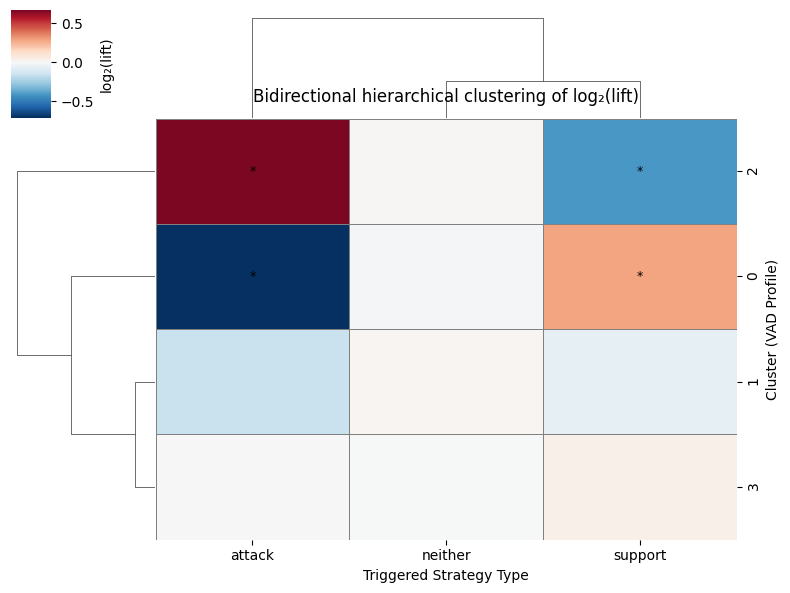

In [ ]:
plot_enrichment_clustermap(
    enrich_perm,
    cluster_col="cluster",
    strategy_col="relation",
    value_col="log2_lift",
    p_col="p_perm",
    sig_level=0.05
)

Analyze the VAD_z of speaker2 under different behaviors

In [ ]:
df_clustered, centers, cluster_dist = cluster_vad_profiles(
    df,
    n_clusters=4,
    vad_cols=["valence_2_z","arousal_2_z","dominance_2_z"],
    label_col="relation"
)


Clustering centers (z-score VAD space):
   valence_2_z  arousal_2_z  dominance_2_z  cluster
0        0.822        1.189          1.088        0
1       -1.005        0.480          0.584        1
2        0.690       -0.144         -0.151        2
3       -0.344       -1.180         -1.202        3


In [ ]:
enrich_perm = permutation_pvals_for_lift(df_clustered, n_perm=1000, strategy_col="relation")
# filter log₂-lift > 0 and p_perm < 0.05:the cases where a strategy truly occurs more often in that emotion cluster
sig = enrich_perm[(enrich_perm["log2_lift"]>0) & (enrich_perm["p_perm"]<0.05)]
top = report_top_by_enrichment(enrich_perm, topk=3, min_count=25,strategy_col="relation")
print(stats)  # chi2, p, cramer_v
sig
# top

{'chi2': np.float64(12.962075942205656), 'dof': 6, 'p': np.float64(0.04364215241396012), 'cramer_v': np.float64(0.03979737894933849)}


,cluster,relation,p_s_given_c,lift,log2_lift,std_resid,p_perm
10,3,neither,0.894931,1.022493,0.032092,0.690449,0.026973


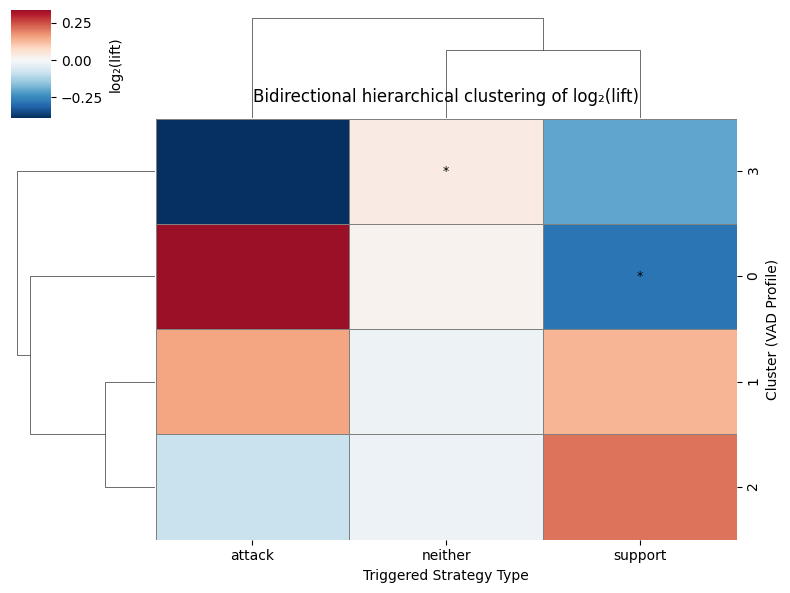

In [ ]:
plot_enrichment_clustermap(
    enrich_perm,
    cluster_col="cluster",
    strategy_col="relation",
    value_col="log2_lift",
    p_col="p_perm",
    sig_level=0.05
)